In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yt
from scipy.optimize import curve_fit

# Helper functions

In [2]:
def droplet_radius(density):
    center = tuple([ l//2 for l in density.shape ])
    rho_d = density[center]
    rho_m = density[0,0,0]
    mass = np.sum(density - rho_m)
    R = (3./4./np.pi*mass/(rho_d-rho_m))**(1./3.)
    return R

In [3]:
def pressure_jump(pressure):
    center = tuple([ l//2 for l in pressure.shape ])
    dP = pressure[center] - pressure[0,0,0]
    return dP

# Surface tension plots

Using Young-Laplace equation

$$\Delta P = \frac{\sigma}{2R_{D}}$$

In [4]:
L = 32
kappa = 0.03
T = 0.5
chi = 1.1
idx = -1
rho = 1.0

In [22]:
R_s = [0.25, 0.3, 0.35]

x = np.zeros(len(R_s))
y = np.zeros(len(R_s))

for i, R in enumerate(R_s):
    ts = yt.load(f"R_{R}/"+"hydro_plt*")
    ds = ts[idx]
    ad = ds.all_data()

    phi = ad[("boxlib", "phi")].reshape(L, L, L)
    pressure = np.zeros([L, L, L])
    for j in range(4, 7):
        pressure += ad[("boxlib", f"mf{j}")].reshape(L, L, L)
    pressure /= 3
    
    dP = pressure_jump(pressure)
    Rd = droplet_radius(phi)
    
    x[i] = 1/(2*Rd)
    y[i] = dP

yt : [INFO     ] 2024-09-03 18:19:41,771 Parameters: current_time              = 20000.0
yt : [INFO     ] 2024-09-03 18:19:41,772 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-09-03 18:19:41,773 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-09-03 18:19:41,774 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-09-03 18:19:41,877 Parameters: current_time              = 20000.0
yt : [INFO     ] 2024-09-03 18:19:41,878 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-09-03 18:19:41,879 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-09-03 18:19:41,879 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-09-03 18:19:41,986 Parameters: current_time              = 20000.0
yt : [INFO     ] 2024-09-03 18:19:41,987 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-09-03 18:19:41,988 Parameters: domain_left_edge          = [0. 0. 0

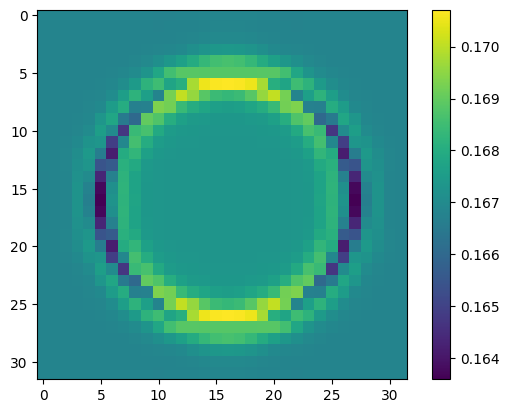

In [23]:
plt.imshow(pressure[:, L//2, :])
plt.colorbar()

Text(0.2, 0.8, '$\\sigma$ = 1.128e-02')

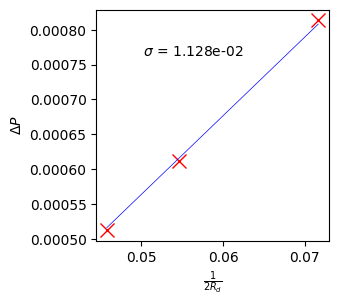

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))

ax.plot(x, y, 'rx', label = "Raw data", ms = 10)
ax.set_ylabel(r"$\Delta P$")
ax.set_xlabel(r"$\frac{1}{2R_d}$")

func = lambda x, a: a*x
popt, pcov = curve_fit(func, x, y)
xfit = np.linspace(x.min(), x.max(), 101)
yfit = func(xfit, *popt)
ax.plot(xfit, yfit, "-b", lw = 0.5)

ax.text(0.2, 0.8, f"$\sigma$ = {popt[0]:.3e}", transform=ax.transAxes)